# COS-Holes + Literature Data Analysis

Since we are seeing a null result, we want to broaden our sample using previously published data and run some statistical analysis on the larger sample to see what kind of results it produces

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob
import astropy
from astropy.io import ascii

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [3]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')

TL;DR
- up_ch = upper limits 
- sum_df = summed values no up lims (USE FOR EVERYTHING BUT VEL PLOT) 
- com_df = comp values no up lims (USE ONLY FOR VEL PLOT)

In [4]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0


In [5]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
4,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1


In [6]:
#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
com_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403,0.099,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,1,1
5,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.00051,13.855,0.052,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.00081,13.652,0.103,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.00109,13.946,0.044,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012,0.076,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211,0.053,54.100,7.973,18.210,5.687,1,1


In [117]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [118]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [119]:
#Borthakur 2013 Data
#https://iopscience.iop.org/article/10.1088/0004-637X/768/1/18/pdf

borthakur = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/borthakur_2013.csv", sep=",")   
borthakur.sort_values('det', inplace=True)
#borthakur

#remove the zero value in the df 
borthakur_no_zero = borthakur.drop(labels=12, axis=0)
#print(borthakur_no_zero)

#arrays for plotting  
civ_B13 = np.array(borthakur_no_zero['logNCIV[i]'])
civ_err_B13 = np.array(borthakur_no_zero['err'])
det_B13 = np.array(borthakur_no_zero['det'])
RpRv_B13 = np.array(borthakur_no_zero['rhokpc[i]/rvir[i]']) #Rproj/Rvir 
Rp_B13 = np.array(borthakur_no_zero['rhokpc[i]'])

In [120]:
#borthakur_no_zero

In [121]:
#Bordoloi 2014 Data 
#https://iopscience.iop.org/article/10.1088/0004-637X/796/2/136/pdf

bordoloi = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/bordoloi_2014_CIV.csv", sep=",") 
bordoloi.sort_values('det', inplace=True)
#bordoloi

#arrays for plotting 
civ_B14 = np.array(bordoloi['logNCIV'])
civ_err_B14 = np.array(bordoloi['err'])
det_B14 = np.array(bordoloi['det'])
RpRv_B14 = np.array(bordoloi['R/Rvir']) #Rproj/Rvir 
Rp_B14 = np.array(bordoloi['R[kpc]'])

In [92]:
#bordoloi

In [97]:
#COS-Halos    

coshalos = {'QSO': ['J0910', 'J1619'],
               'Rproj/Rvir': [0.34, 0.39],
               'Rproj': [112, 97],
               'NCIV': [14.10, 13.90],
               'sigNCIV': [0.09, 0.03]}
COSHALOS = pd.DataFrame(data=coshalos)

In [98]:
COSHALOS

,QSO,Rproj/Rvir,Rproj,NCIV,sigNCIV
0,J0910,0.34,112,14.1,0.09
1,J1619,0.39,97,13.9,0.03


In [46]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

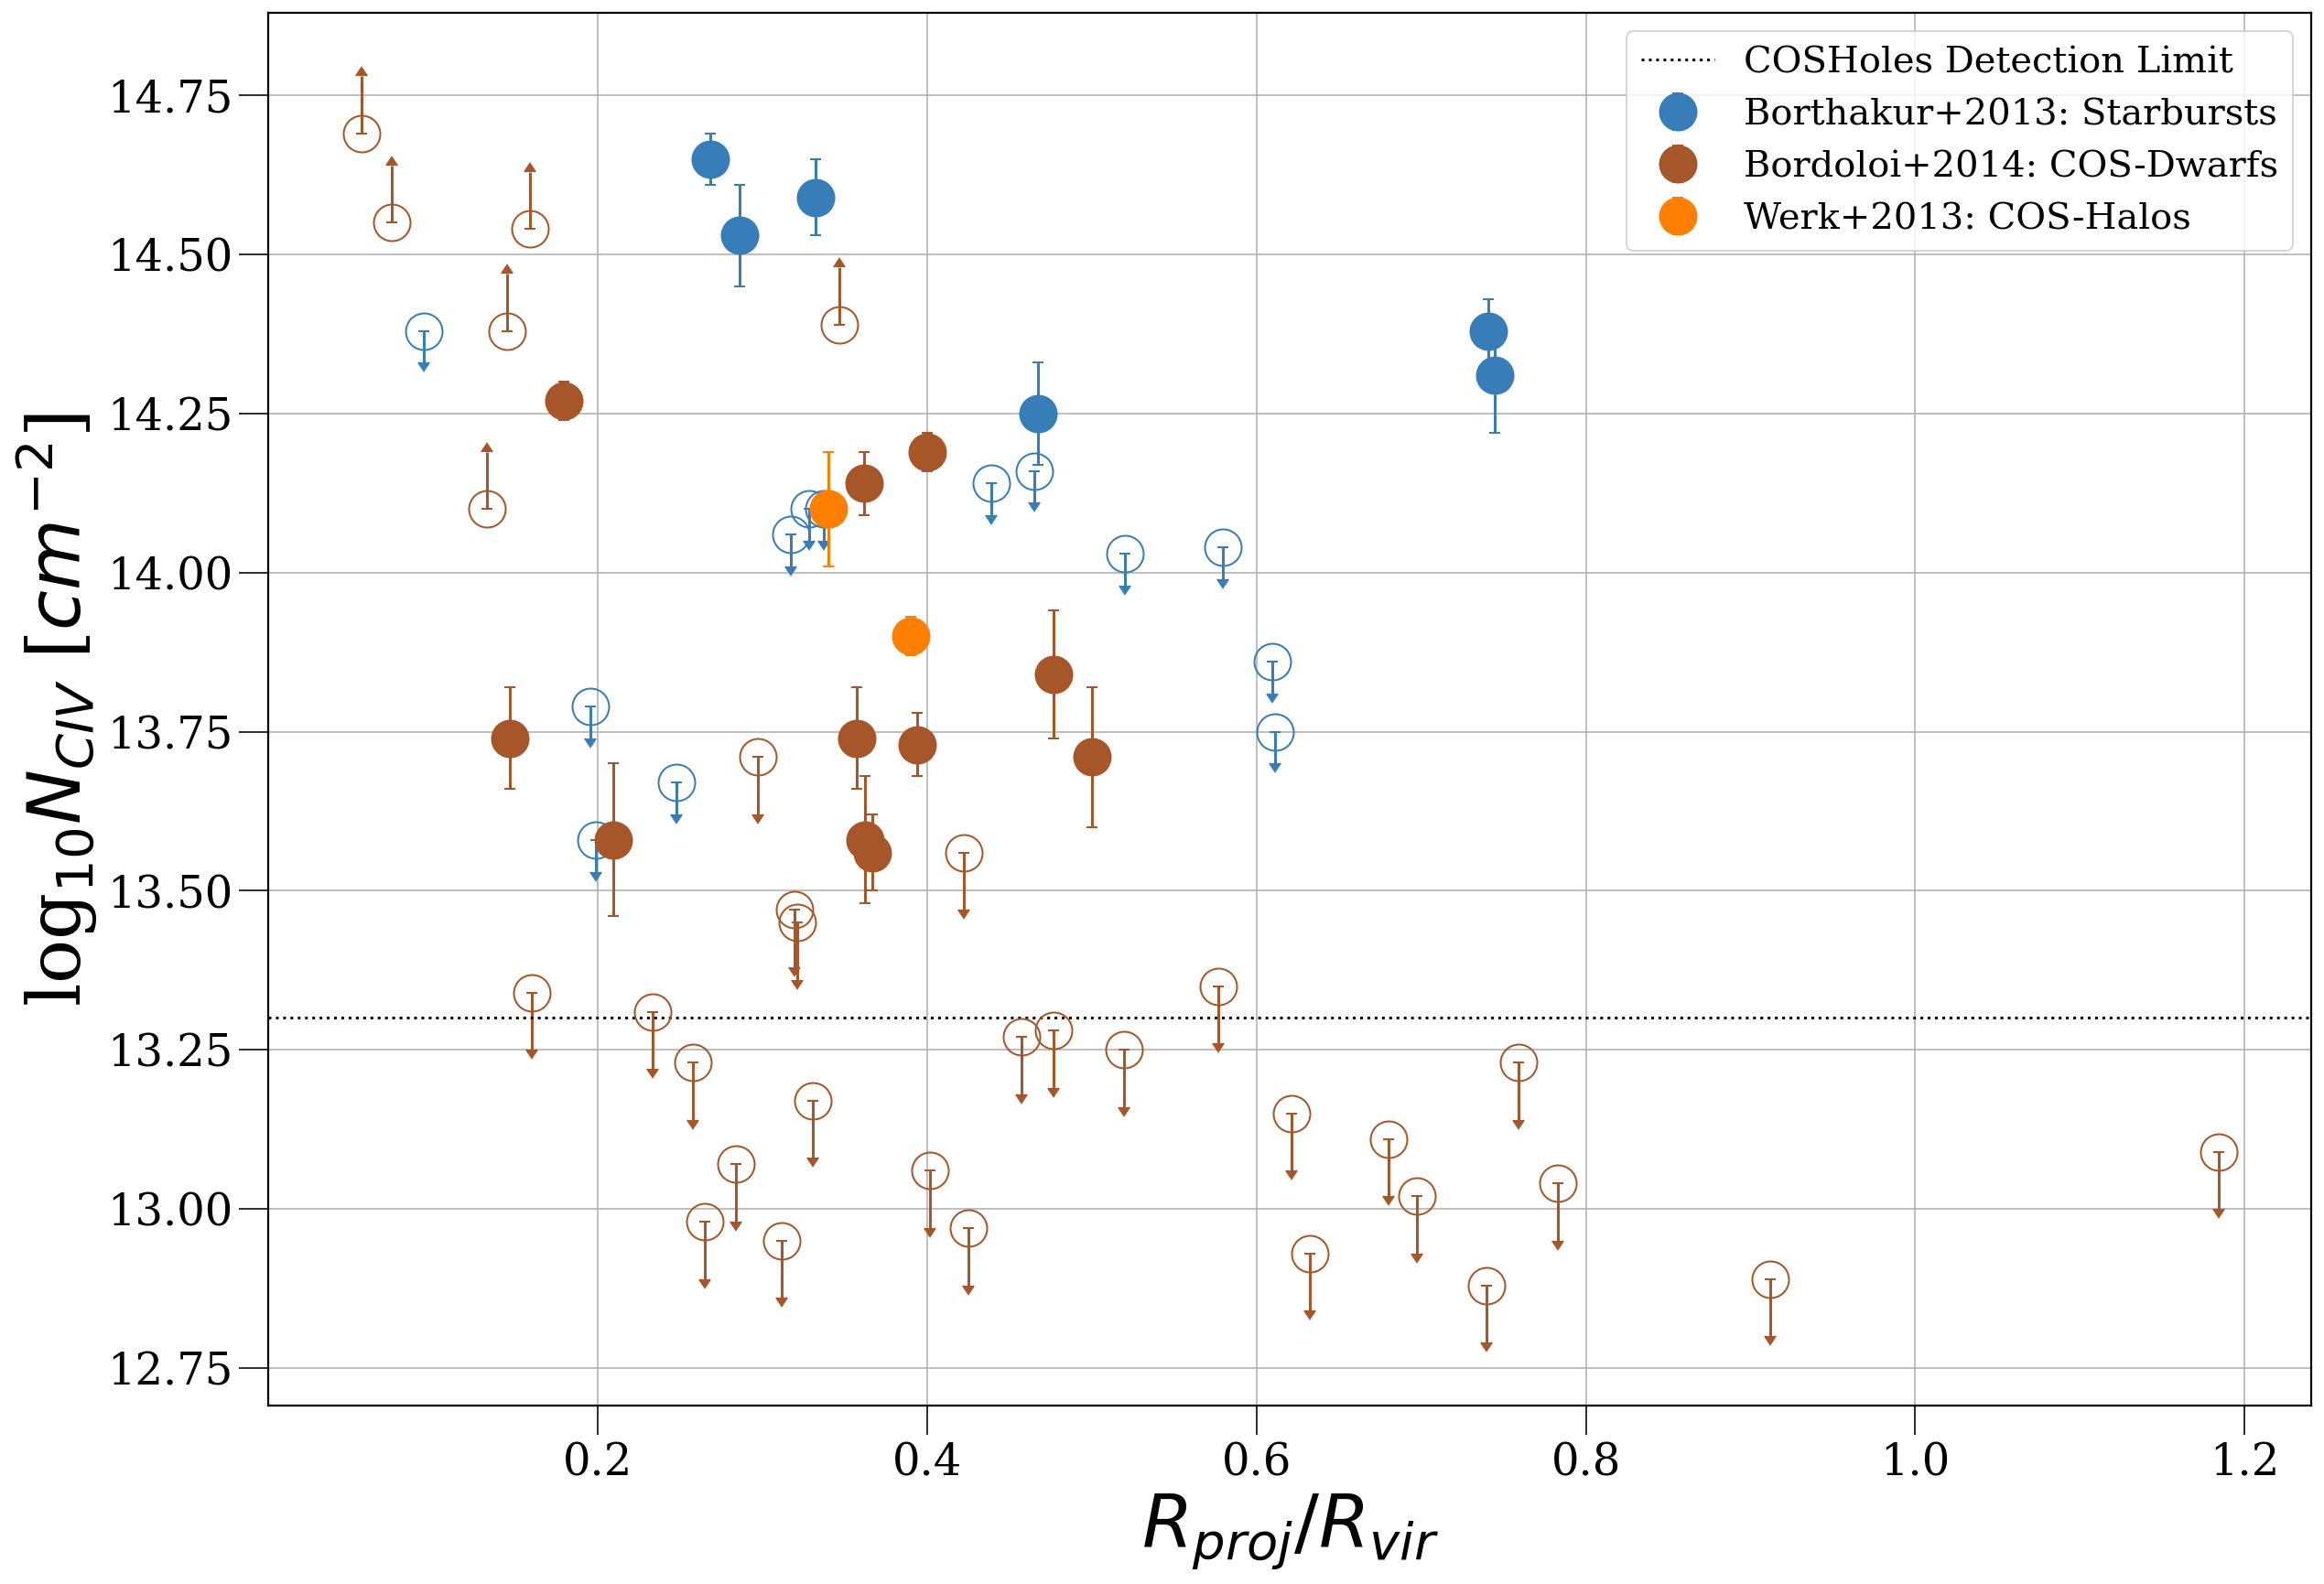

In [99]:
#Just plotting the data for fun before I start 

########Borthakur 2013
#Non-Detections
plt.errorbar(RpRv_B13[:13], civ_B13[:13], yerr = civ_err_B13[14], capsize=3, c = CB_color_cycle[0], 
             marker = 'o', markersize=20, ls='none', mfc='none', uplims=True)
#Detections
plt.errorbar(RpRv_B13[13:], civ_B13[13:], yerr = civ_err_B13[13:], capsize=3, c = CB_color_cycle[0], label = 'Borthakur+2013: Starbursts', 
             marker = 'o', markersize=20, ls='none')

#######Bordoloi 2014
#Non-Detections
plt.errorbar(RpRv_B14[:26], civ_B14[:26], yerr = civ_err_B13[15], capsize=3, c = CB_color_cycle[4], 
            marker = 'o', markersize = 20, ls='none', mfc='none', uplims=True)
plt.errorbar(RpRv_B14[37:], civ_B14[37:], yerr = civ_err_B13[15], capsize=3, c = CB_color_cycle[4], 
            marker = 'o', markersize = 20, ls='none', mfc='none', lolims=True)
#Detections
plt.errorbar(RpRv_B14[26:37], civ_B14[26:37], yerr = civ_err_B14[26:37], capsize=3, c = CB_color_cycle[4], label = 'Bordoloi+2014: COS-Dwarfs', 
            marker = 'o', markersize = 20, ls='none')

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=20, ls='none')


plt.xlabel('$R_{proj} / R_{vir}$ ')
plt.ylabel('log$_{10}N_{CIV}$ [$cm^{-2}$]')
plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')
#plt.ylim(12.6,15)
#plt.xscale("log")
plt.legend()
plt.grid(True)
plt.show()

<>:40: DeprecationWarning: invalid escape sequence \p
<>:40: DeprecationWarning: invalid escape sequence \p
<>:40: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/3199448420.py:40: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=20, label='M31 (Lehner et al 2020) AOD; log$M_{BH}$ = 8.15$\pm$0.24', ls='none')


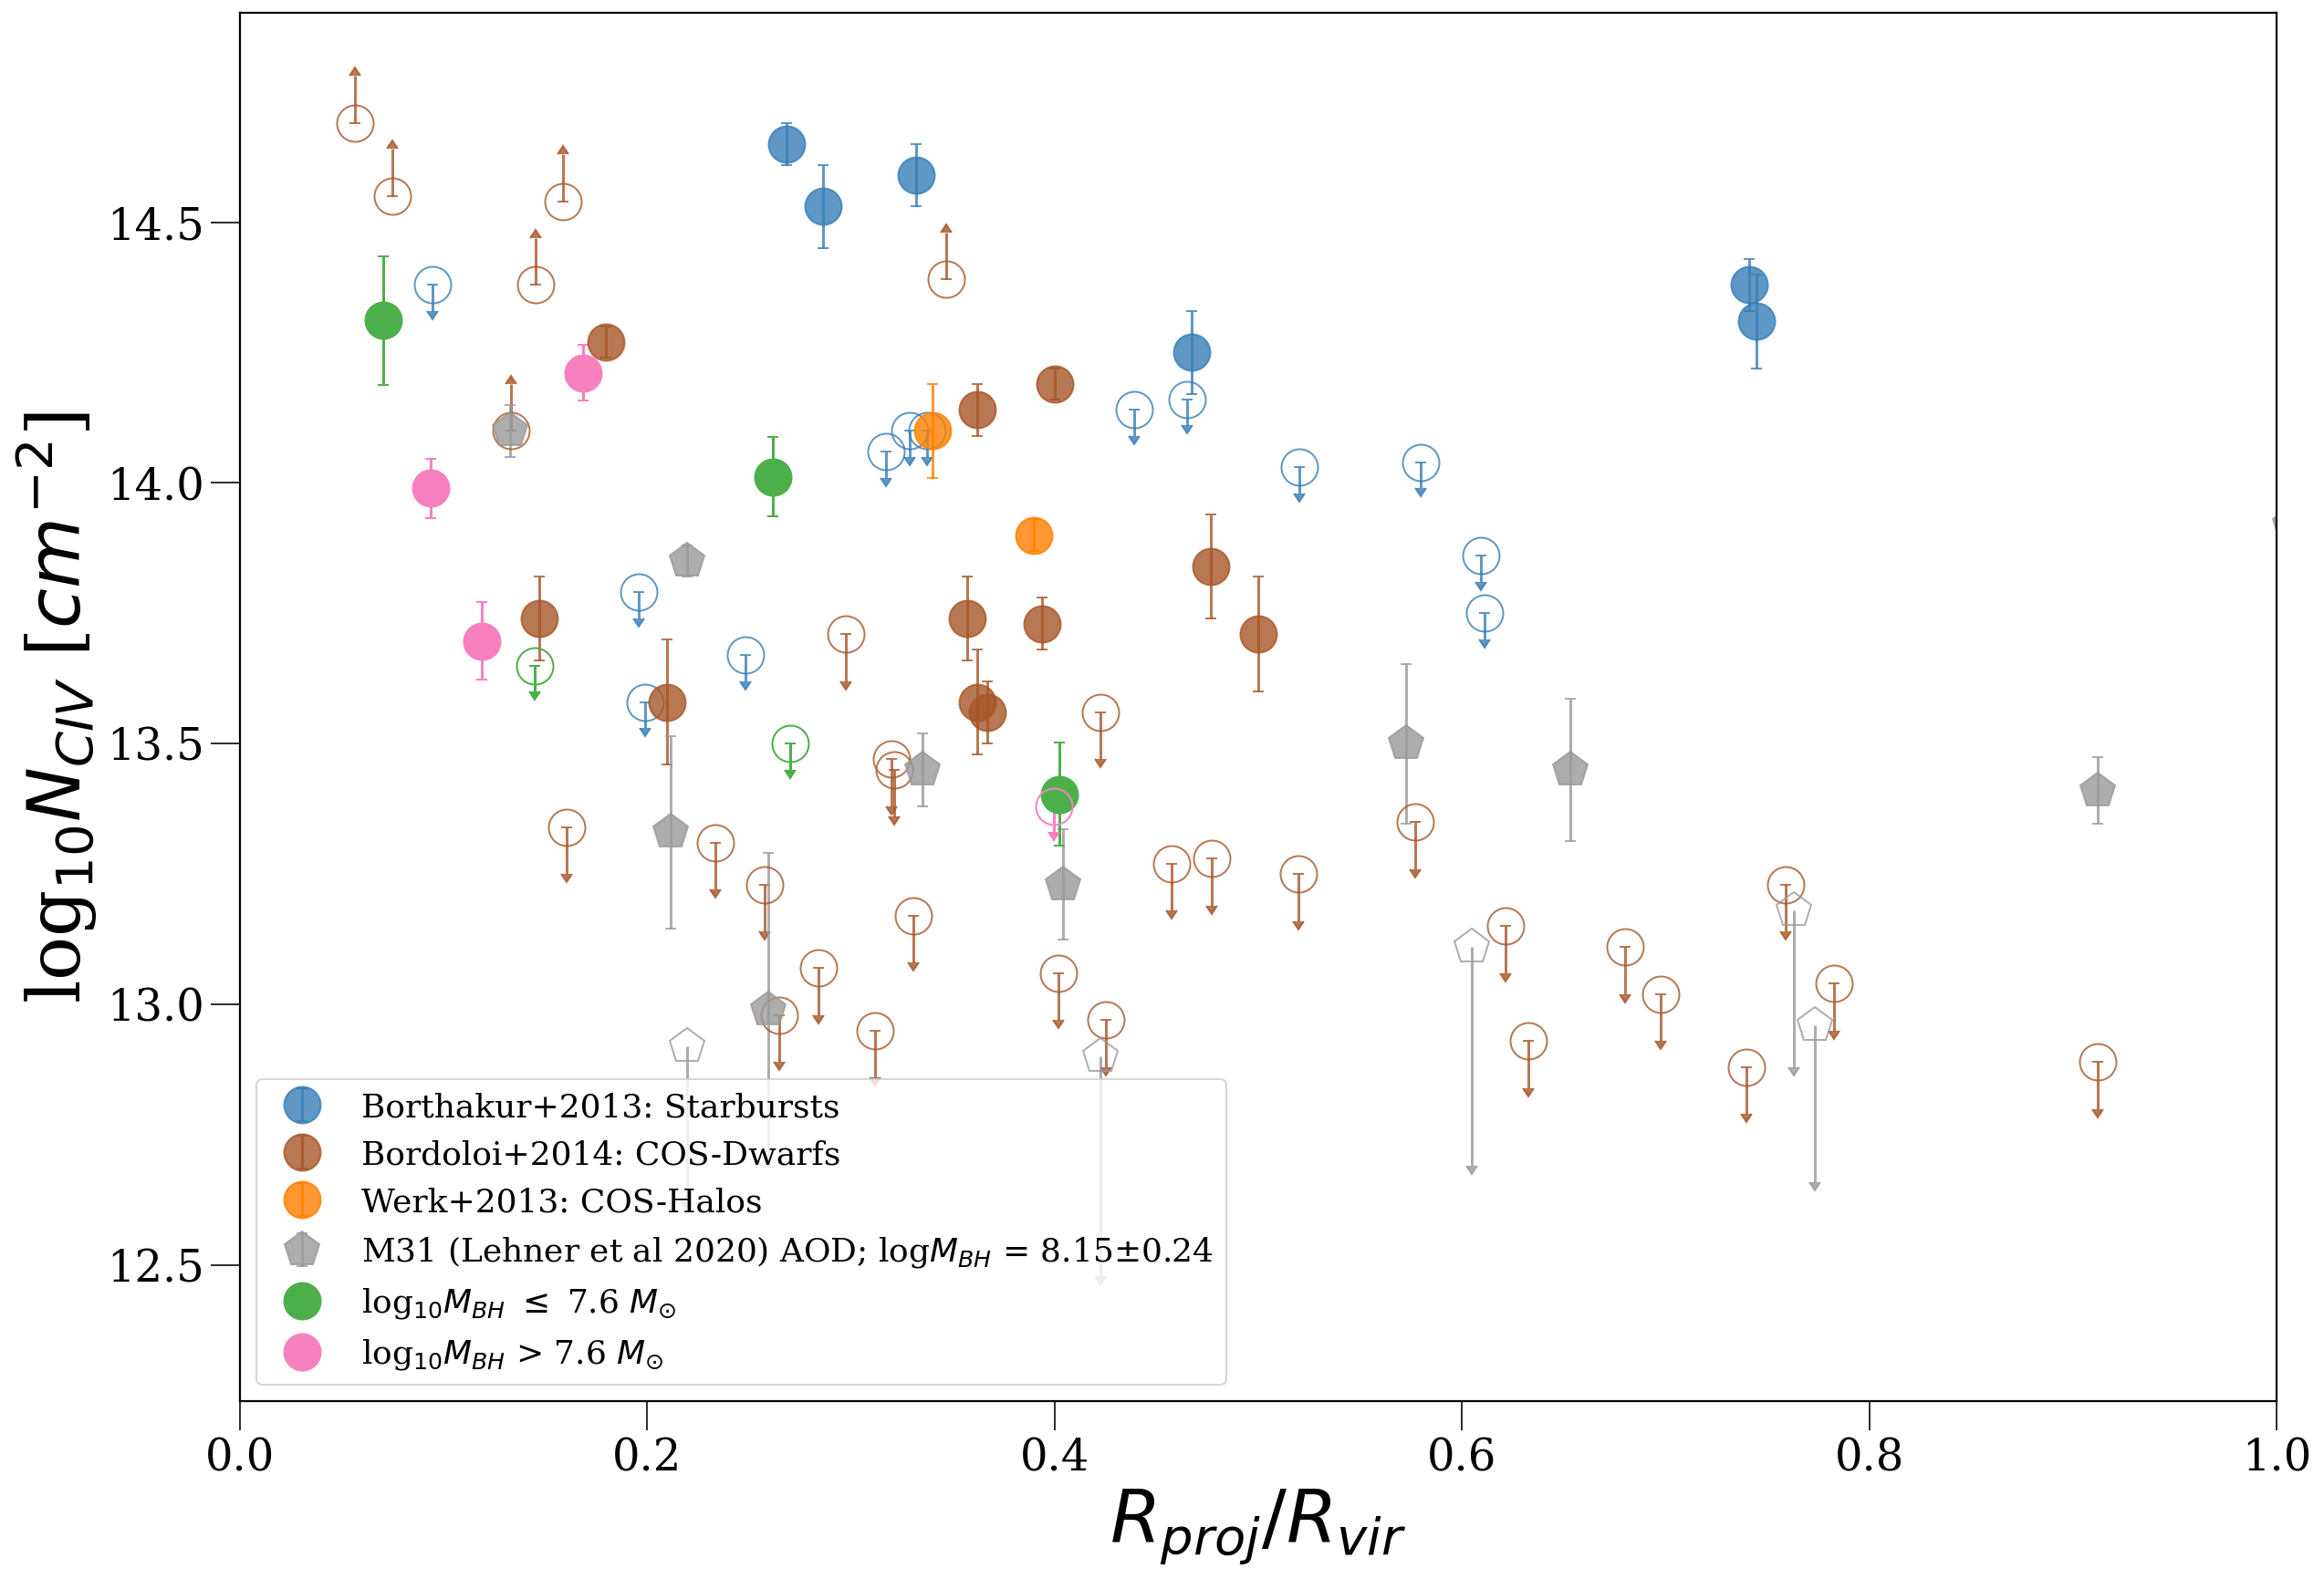

In [105]:
#Just plotting the data for fun before I start 

#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)
    

#Plotting NCIV vs MBH    
fig, ax = plt.subplots()

########Borthakur 2013
#Non-Detections
plt.errorbar(RpRv_B13[:13], civ_B13[:13], yerr = civ_err_B13[14], capsize=3, c = CB_color_cycle[0], 
             alpha=0.8, marker = 'o', markersize=20, ls='none', mfc='none', uplims=True)
#Detections
plt.errorbar(RpRv_B13[13:], civ_B13[13:], yerr = civ_err_B13[13:], capsize=3, c = CB_color_cycle[0], label = 'Borthakur+2013: Starbursts', 
             alpha =0.8, marker = 'o', markersize=20, ls='none')

#######Bordoloi 2014
#Non-Detections
plt.errorbar(RpRv_B14[:26], civ_B14[:26], yerr = civ_err_B13[15], capsize=3, c = CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 20, ls='none', mfc='none', uplims=True)
plt.errorbar(RpRv_B14[37:], civ_B14[37:], yerr = civ_err_B13[15], capsize=3, c = CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 20, ls='none', mfc='none', lolims=True)
#Detections
plt.errorbar(RpRv_B14[26:37], civ_B14[26:37], yerr = civ_err_B14[26:37], capsize=3, c = CB_color_cycle[4], label = 'Bordoloi+2014: COS-Dwarfs', 
            alpha=0.8, marker = 'o', markersize = 20, ls='none')

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=20, ls='none', alpha=0.8)

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.8, marker="p", markersize=20, label='M31 (Lehner et al 2020) AOD; log$M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha=0.8, marker="p",mfc='none',markersize=20, ls='none')

########################################################

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
#ax.set_ylim(12.5, 14.6)
ax.set_xlim(0, 1)
plt.show()

### Setting up Stellar Mass Bins 

Since we are still seeing a null result I want to investigate how the stellar mass may be impacting the sample so will split the larger sample into a stellar mass bin that only has values between 10^10-11 and use data from 0-150 kpc (since that is where we see the most "consistency")

In [79]:
####### BORTHAKUR ######### => Only has high stellar mass bin values 

borthakur_less150 = borthakur_no_zero.loc[(borthakur_no_zero['rhokpc[i]'] <= 150)]
#borthakur_less150
borthakur_high = borthakur_less150.loc[(borthakur_less150['mstar[i]'] >= 10) & (borthakur_less150['mstar[i]'] <= 11)]
borthakur_high

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det
16,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.00,0
13,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.00,0
8,J102846.43+391842.9,10.50,12.029020,330.32571,88.7,0.268523,14.65,0.04,1
14,J140502.20+470525.9,10.43,11.964435,314.35077,146.9,0.467312,14.25,0.08,1


In [80]:
####### BORDOLOI ######### 

bordoloi_less150 = bordoloi.loc[(bordoloi['R[kpc]'] <= 150) & (bordoloi['logM*'] >= 9) ]
#bordoloi_less150

#separating into the stellar mass sample: 10-11
#bordoloi_low = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 9) & (bordoloi_less150['logM*'] < 10)]
    #Due to the new stellar mass bin idea, we don't need the bordoloi low
bordoloi_high = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 10) & (bordoloi_less150['logM*'] <= 11)]

bordoloi_high

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
25,J1211+3657,13.17,0.00,0,10.1,90,272,0.330882
26,J1121+0325,13.45,0.00,0,10.1,89,277,0.321300
1,J09525+4535,13.56,0.06,1,10.0,95,259,0.366795
15,PG1202+281,13.58,0.10,1,10.0,92,254,0.362205
12,J0959+0503,14.69,0.00,2,10.0,14,247,0.056680


## Best fit line through all COS-Holes Data

In [18]:
#The best fit line uses the upper limits in the fitting equations so I need a df that has the sums and the uplims which i dont have 
    #right now. So I need to make a new one and this one will just be used to create the fit and I will use the ones from before to 
    #plot like I have been 
    
sum_wups_ch = cosholes_df.loc[(cosholes_df['comp'] > 0)]
sum_wups_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.002230,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.003300,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.650000,0.050000,0.000,0.000,0.000,0.000,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.500000,0.050000,0.000,0.000,0.000,0.000,1,0
4,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.000000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.004420,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.002750,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.10,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.004220,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.000000,...,1550.781,0.003809,13.380000,0.050000,0.000,0.000,0.000,0.000,1,0


In [19]:
##### CIV #####

XX =  np.copy(sum_wups_ch['Rproj/Rvir']) #Getting the impact parameter from my galaxy parameters table 
YY = np.copy(sum_wups_ch["N"]) #getting the column density of CIV from main data table 
YY_err = np.copy(sum_wups_ch["sigN"]) #column density error of CIV 
has_UL = YY_err <= 0.05 #determining the ones that have upper limts (in his table they are denoted with -1 in the error column) T/F

Ylim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)
Ylim[has_UL] = 1 #if this array has a -1 values (upper limit) then it is given the value of 1 
Xlim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)

coeff = "kendallt" # the correlation coefficient 
Nboot = 10_000 #number of bootstrapping iterations over which the uncertainties are estimated 

xCrr = XX #same as XX => impact parameters 
yCrr = YY #same as YY => column densities 
yCrr_err = YY_err #same as YY_err => column density error 
xlimCrr = Xlim #array of 0s same length as XX or Xlim 
ylimCrr = Ylim #array od 0s and 1s same length as YY or Ylim (1 if it is an upper limit)

kwargs = {"return_dist":True}
res = pymccorrelation(xCrr, yCrr, xlim = xlimCrr, ylim = ylimCrr, coeff = coeff, Nboot = Nboot, **kwargs)

outCrr = {} #Where the stat information is stored 

outCrr["coeff_percentiles"] = res[0]
outCrr["p-value_percentiles"] = res[1]
outCrr["coeff_dist"] = res[2]
outCrr["p-value_dist"] = res[3]

mc_datarr = {
    "Ion":["CIV"]*len(outCrr["coeff_dist"]),
    r"Kendall's $\tau$":outCrr["coeff_dist"],
    r"$\log_{10}$(p-value)":np.log10(outCrr["p-value_dist"])
}

/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/pymccorrelation/pymccorrelation.py:161: RuntimeWarning: invalid value encountered in double_scalars
  z = S/ _np.sqrt(var)


In [20]:
##### CIV #####

upper_lim_Crr = yCrr_err < 0 #a mask to find the upper limits for later stuff I think 

delta_Crr = np.invert(upper_lim_Crr) #array of True and False 
xsig_Crr = np.zeros_like(xCrr) #array of 0s like xC => like XX => the impact parameters bc they dont have error oh i see
ysig_Crr = yCrr_err[:] #error of the column densities 

lmcens_Crr = linmix.LinMix(xCrr, yCrr, xsig_Crr, ysig_Crr, delta=delta_Crr, K=2)
lmcens_Crr.run_mcmc(silent=True)

yints_Crr = lmcens_Crr.chain['alpha'] #same shape as the Nboot (looks like 12-14 values)
slopes_Crr = lmcens_Crr.chain['beta'] #same shape as the Nboot (looks like very very small values)

mean_yint_Crr = yints_Crr.mean() #mean alpha value (~14)
mean_slope_Crr = slopes_Crr.mean() #mean beta value (~ -0.010)

xxrr = np.linspace(0,1,1000) #This is how long the line is gonna be
all_lines_Crr = np.array([m*xxrr + b for (m,b) in zip(slopes_Crr, yints_Crr)]) #makng the equation

lo_line_Crr, med_line_Crr, hi_line_Crr = np.percentile(all_lines_Crr, (16,50,84), axis = 0) #percentiles for stats knowledge
mean_line_Crr = mean_slope_Crr*xxrr + mean_yint_Crr #mean line equation

In [83]:
 bordoloi_high['logNCIV'][:2]

25    13.17
26    13.45
Name: logNCIV, dtype: float64

<>:15: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/1966884714.py:15: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)


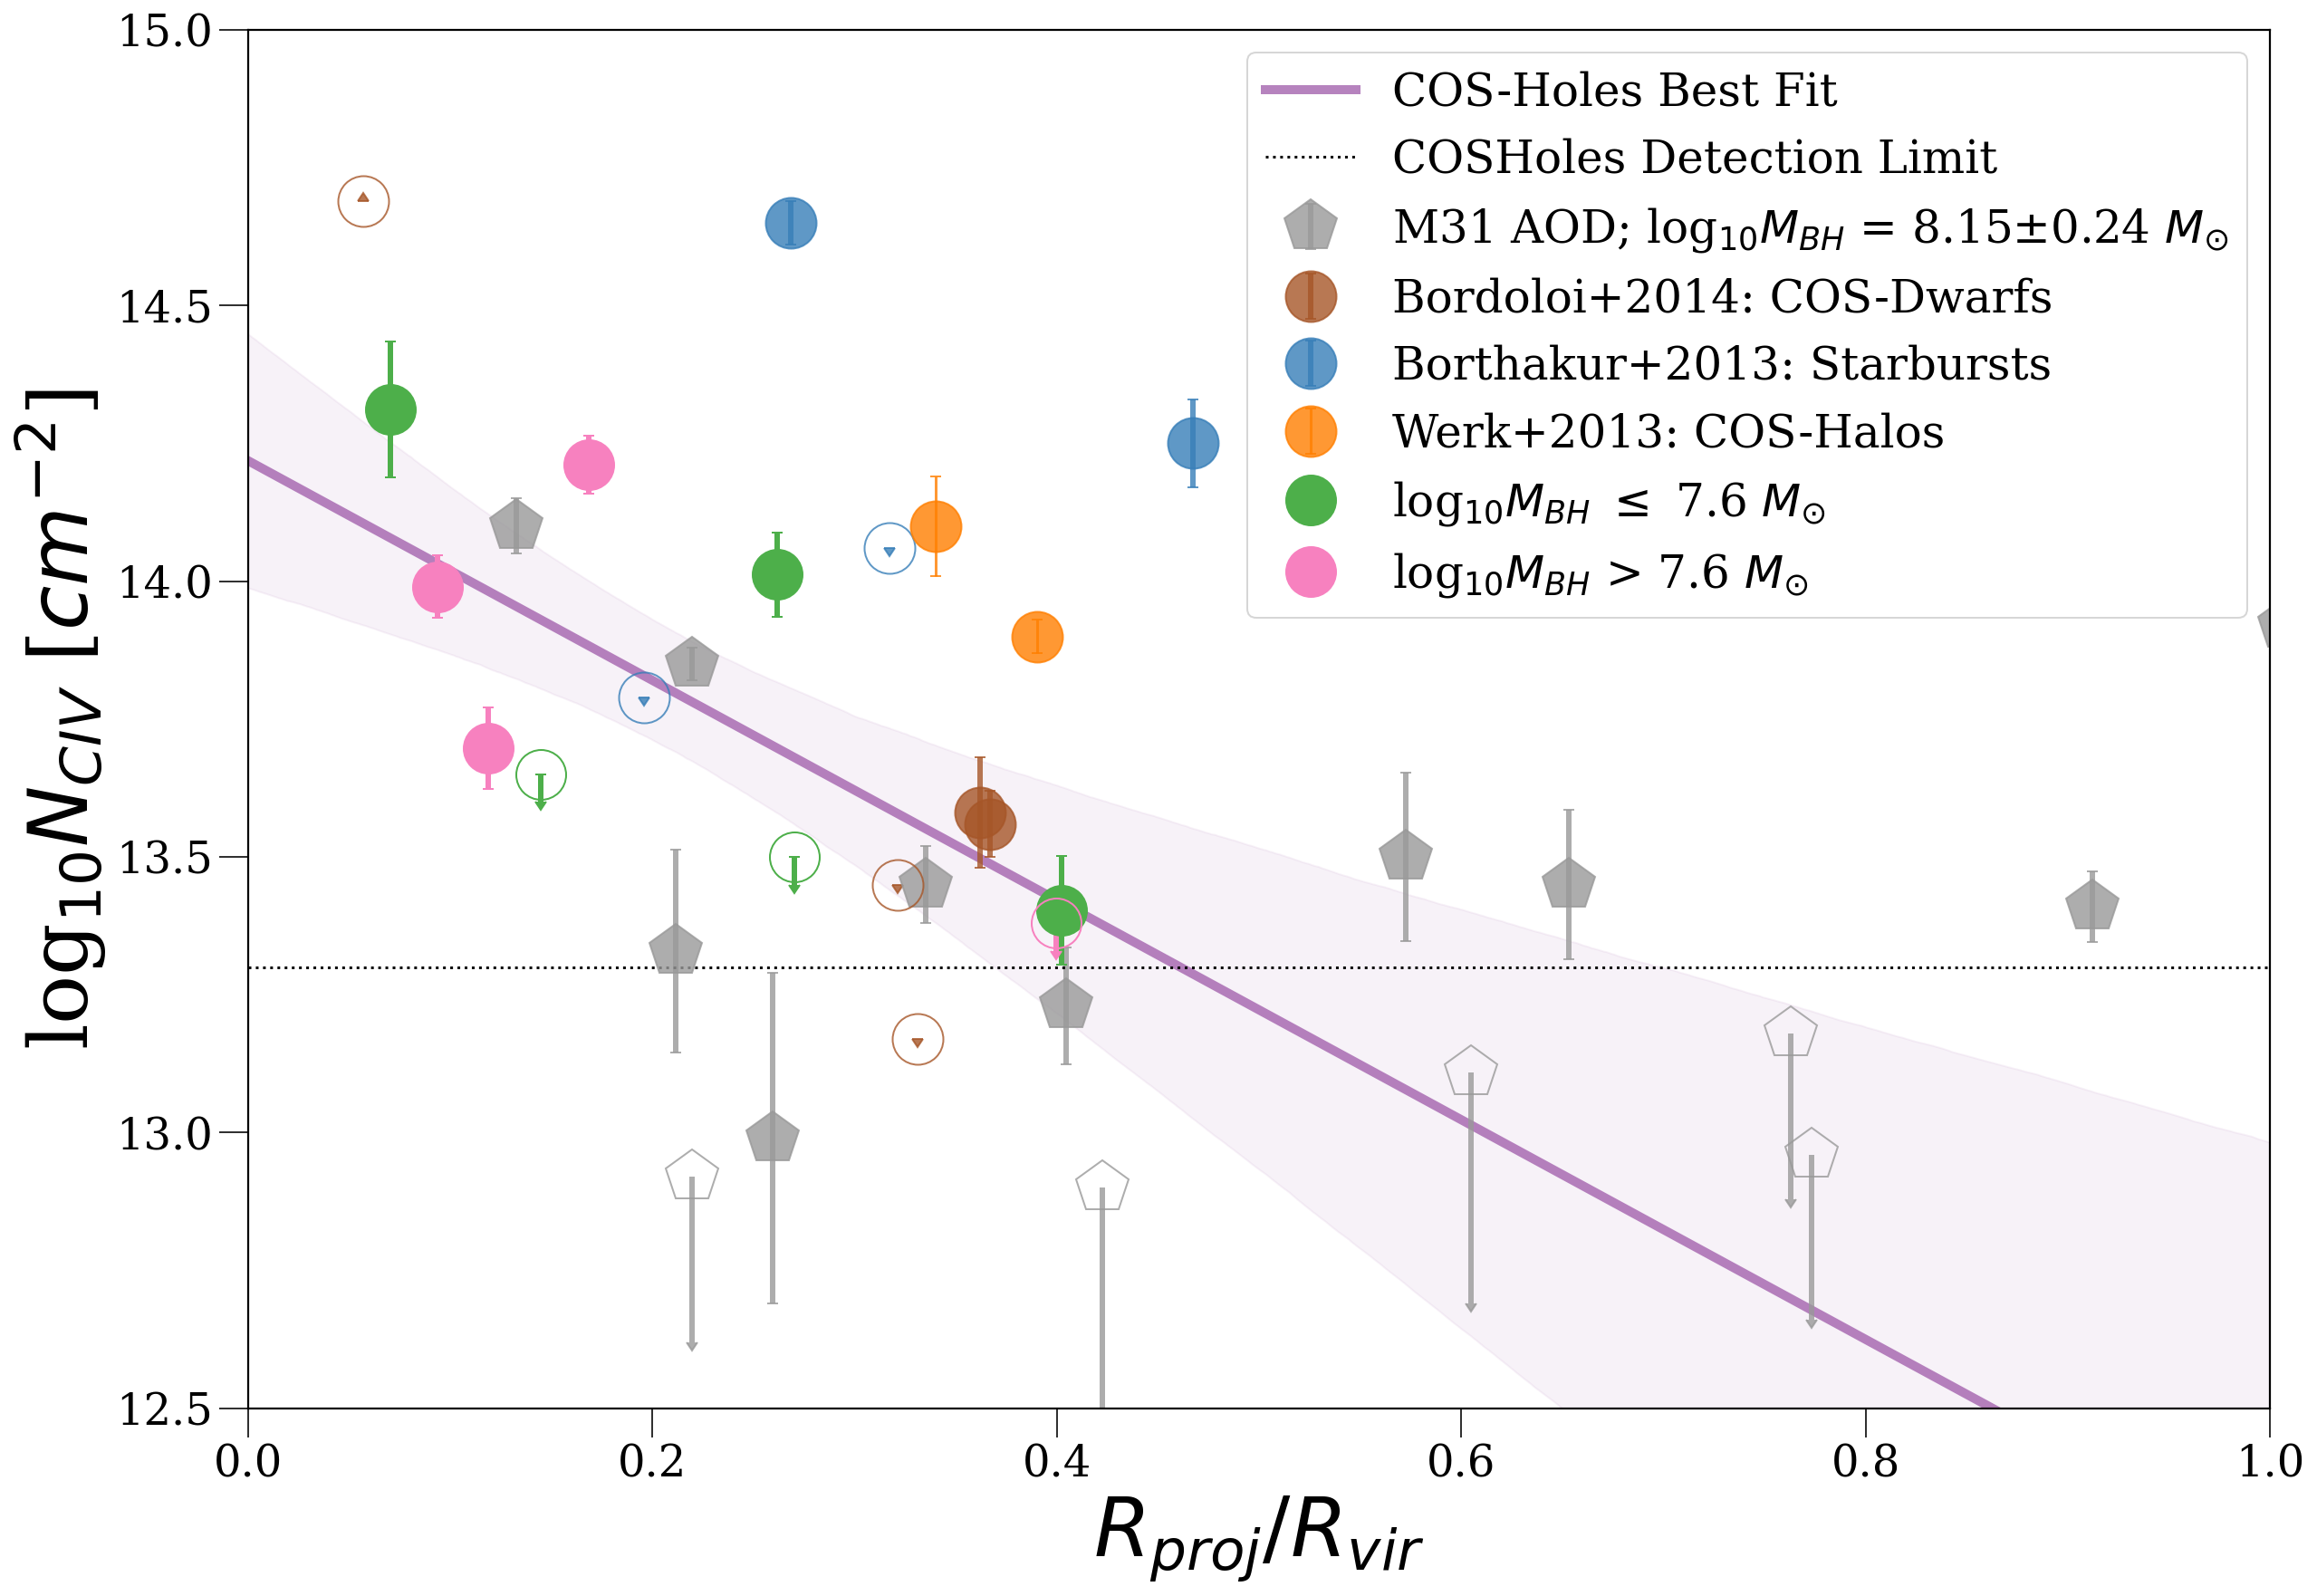

In [106]:
#Plotting NCIV vs Rproj/Rvir with the best fit line and literature data

fig, ax = plt.subplots()

plt.plot(xxrr, mean_line_Crr, color = CB_color_cycle[5], lw = 5, ls = "-", alpha = 0.7, label='COS-Holes Best Fit')
plt.fill_between(xxrr, lo_line_Crr, hi_line_Crr, color =CB_color_cycle[5], alpha = 0.07)

################################# LITERATURE DATA #######################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha=0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

############### Stellar Mass (10-11) Literature Sample ##############

#Non-Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][:2], bordoloi_high['logNCIV'][:2], yerr = bordoloi_high['err'][:2], capsize=3,c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit

    #Borthakur 
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][:2], borthakur_high['logNCIV[i]'][:2], yerr = borthakur_high['err'][:2], capsize=3, 
                c = CB_color_cycle[0], alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit
#Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][2:4], bordoloi_high['logNCIV'][2:4], yerr = bordoloi_high['err'][2:4], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', label = 'Bordoloi+2014: COS-Dwarfs', elinewidth=3)
plt.errorbar(bordoloi_high['R/Rvir'][4:], bordoloi_high['logNCIV'][4:], yerr = bordoloi_high['err'][4:], capsize=3, c =CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', lolims=True, elinewidth=3) #lower limit 
    #Borthakur
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][2:], borthakur_high['logNCIV[i]'][2:], yerr = borthakur_high['err'][2:], capsize=3, 
                alpha=0.8, c = CB_color_cycle[0], marker = 'o', markersize = 28, ls='none', label = 'Borthakur+2013: Starbursts', elinewidth=3) 

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)

#####COS-HOLES DATA##### 

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 1)
#plt.savefig('Figures/lit_rr_cos_best_fit.png')
plt.show()

In [27]:
print('COS-HOLES Fits')
print('y intercept:', mean_yint_Crr)
print('slope:', mean_slope_Crr)

COS-HOLES Fits
y intercept: 14.21835317334846
slope: -1.9914937715056031


### Discussion Plots from COS_Analysis.ipynb but COS-Holes data as one sample

#### EAGLE

In [28]:
df_rr_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
df_rr_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.7.6_8.6.dat",sep="\s+")

df_r_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
df_r_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.7.6_8.6.dat",sep="\s+")

<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/2210995085.py:1: DeprecationWarning: invalid escape sequence \s
  df_rr_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_378

<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/3005297406.py:13: DeprecationWarning: invalid escape sequence \l
  color = CB_color_cycle[5], lw = 5, label = 'EAGLE:  6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/3005297406.py:22: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)
/var/folders/cm/j7lkwsrd7j

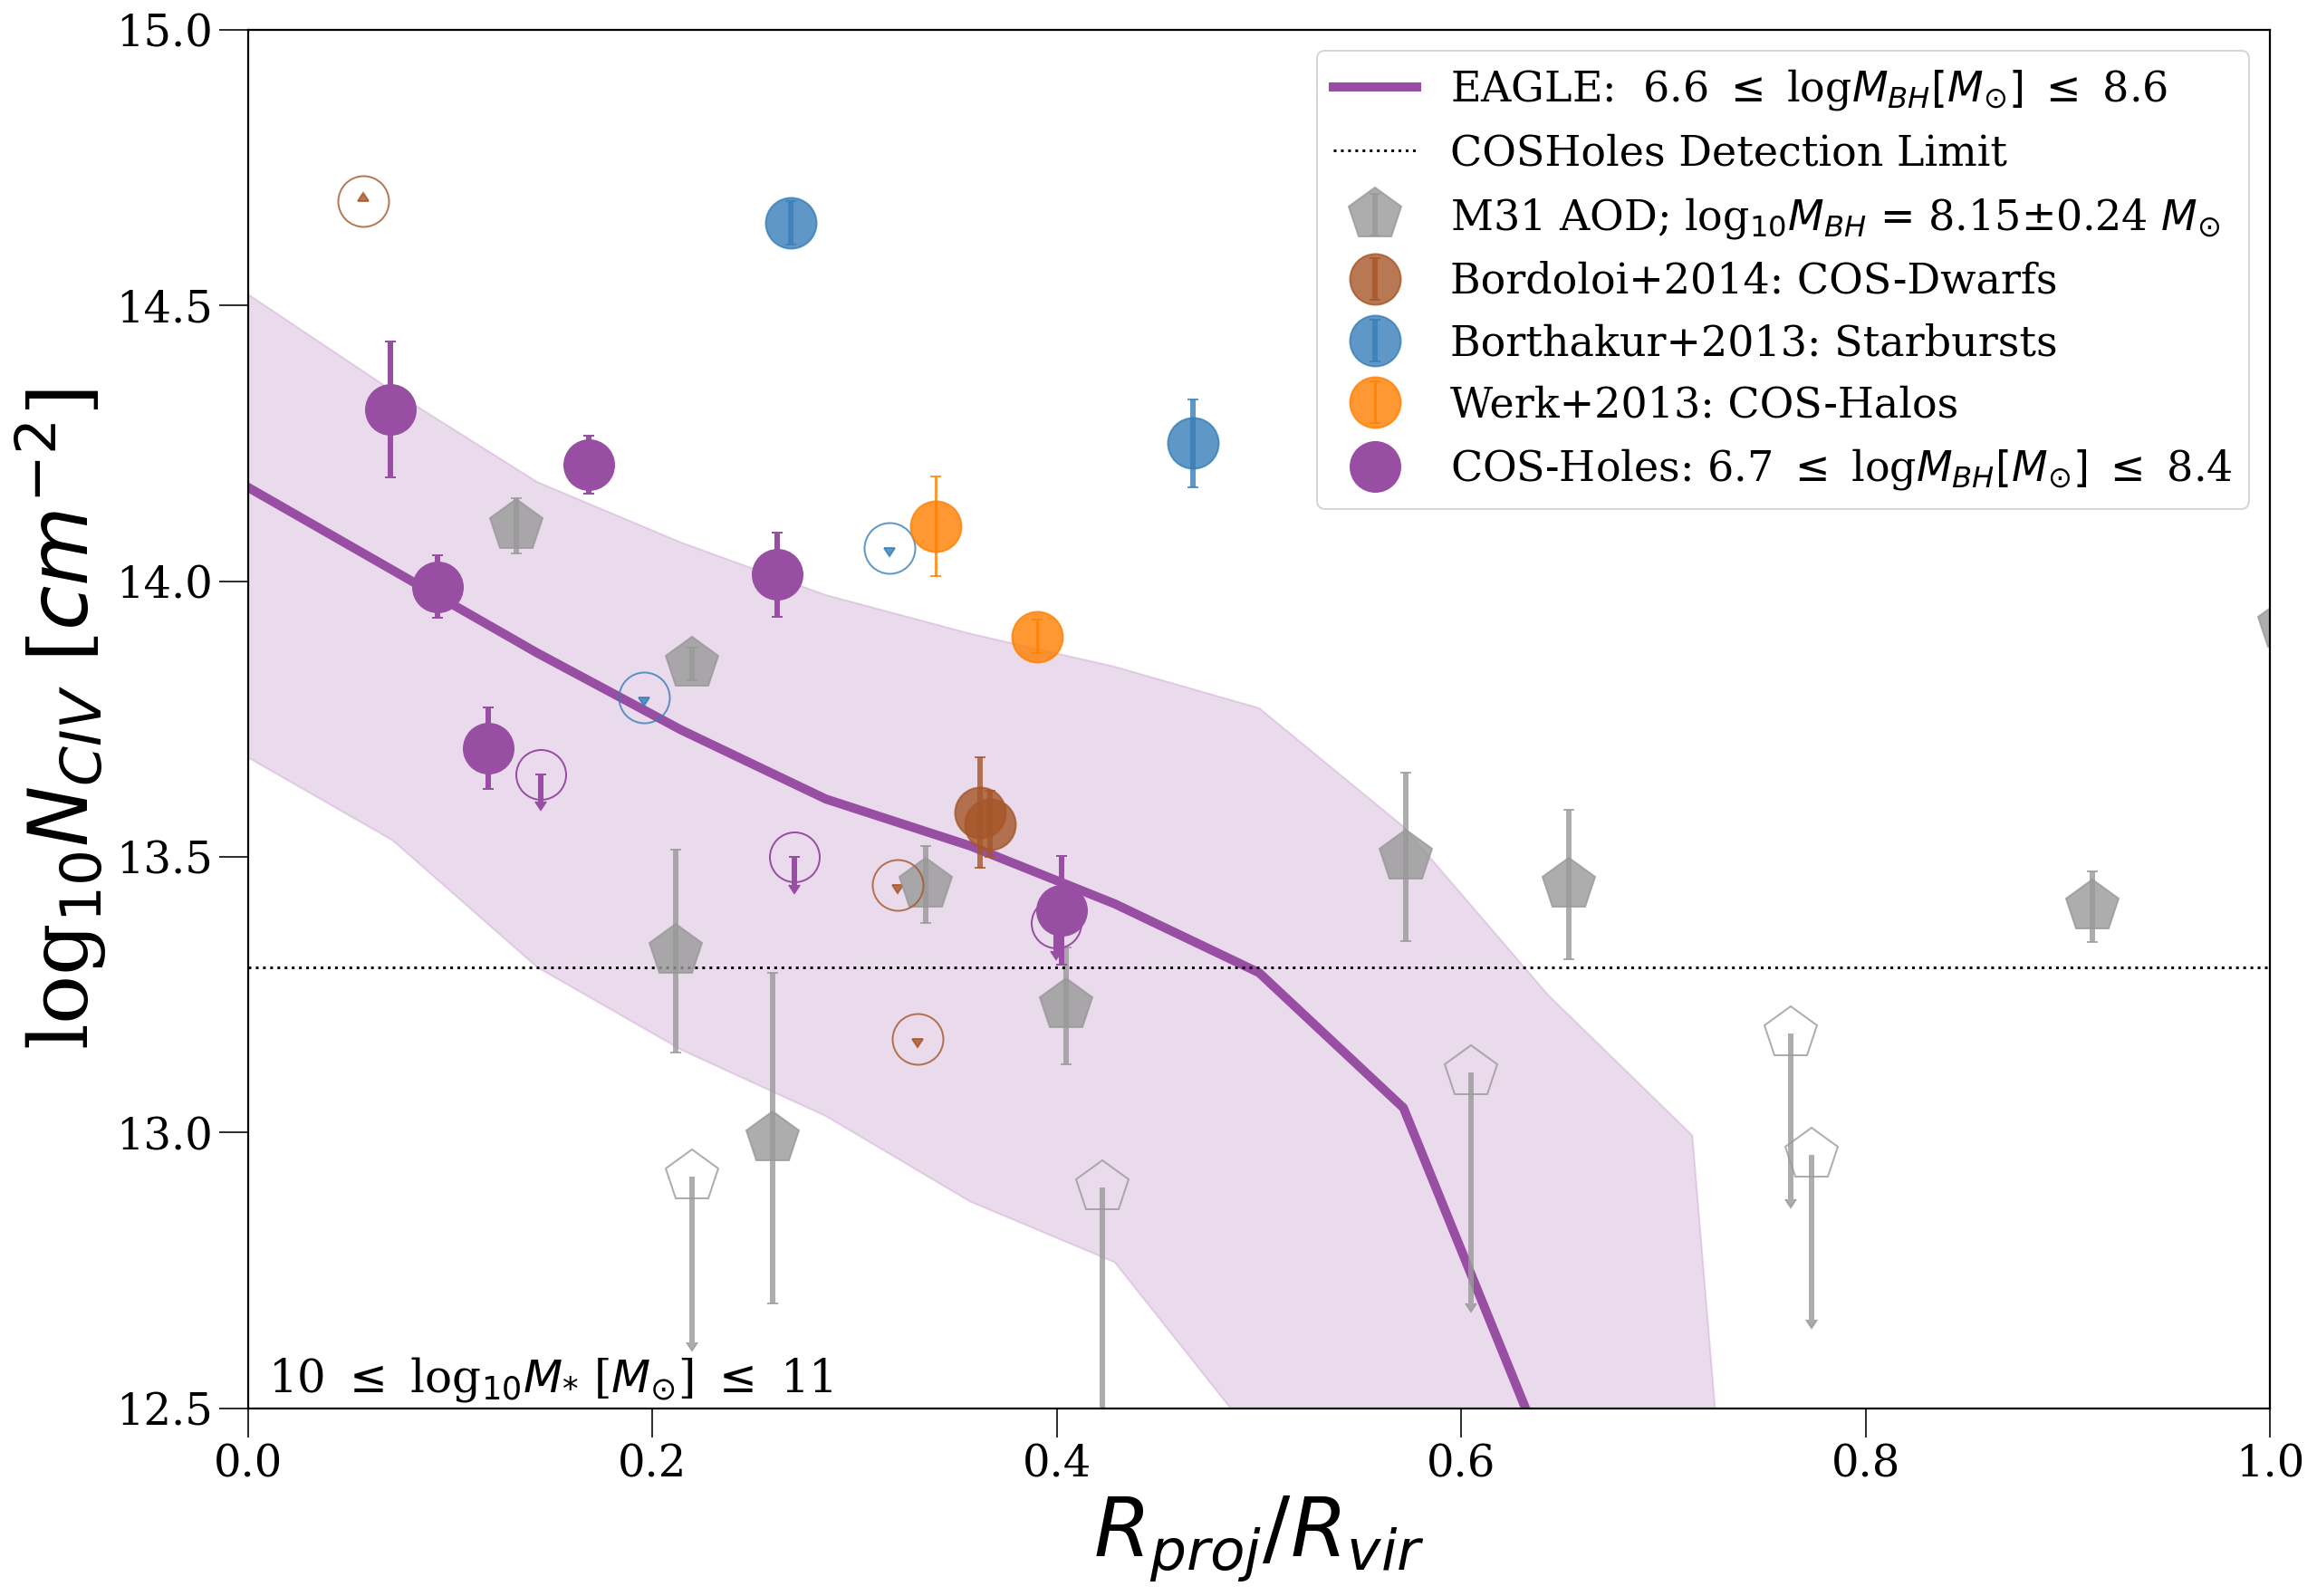

In [107]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#EAGLE

plt.fill_between((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, 
                 (df_rr_new_low['16percentile'] + df_rr_new_high['16percentile'])/2, 
                 (df_rr_new_low['84percentile'] + df_rr_new_high['84percentile'])/2, alpha = 0.2, color = CB_color_cycle[5])
plt.plot((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, (df_rr_new_low['median'] + df_rr_new_high['median'])/2, 
         color = CB_color_cycle[5], lw = 5, label = 'EAGLE:  6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha=0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

############### Stellar Mass (10-11) Literature Sample ##############

#Non-Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][:2], bordoloi_high['logNCIV'][:2], yerr = bordoloi_high['err'][:2], capsize=3,c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit

    #Borthakur 
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][:2], borthakur_high['logNCIV[i]'][:2], yerr = borthakur_high['err'][:2], capsize=3, 
                c = CB_color_cycle[0], alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit
#Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][2:4], bordoloi_high['logNCIV'][2:4], yerr = bordoloi_high['err'][2:4], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', label = 'Bordoloi+2014: COS-Dwarfs', elinewidth=3)
plt.errorbar(bordoloi_high['R/Rvir'][4:], bordoloi_high['logNCIV'][4:], yerr = bordoloi_high['err'][4:], capsize=3, c =CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', lolims=True, elinewidth=3) #lower limit 
    #Borthakur
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][2:], borthakur_high['logNCIV[i]'][2:], yerr = borthakur_high['err'][2:], capsize=3, 
                alpha=0.8, c = CB_color_cycle[0], marker = 'o', markersize = 28, ls='none', label = 'Borthakur+2013: Starbursts', elinewidth=3) 

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for colour, label in zip([CB_color_cycle[5]], [r"COS-Holes: 6.7 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.4"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"], sum_ch['N'],yerr=sum_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"], up_ch['N'], yerr=up_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

plt.annotate('10 $\leq$ log$_{10}M_{*}$ [$M_{\odot}$] $\leq$ 11', (0.01, 12.53), fontsize=25)
ax.legend(loc=1, fontsize=23)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 1)
plt.savefig('Figures/nciv_eaglesum_vs_rr.png')
plt.show()

<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/3047214149.py:13: DeprecationWarning: invalid escape sequence \l
  color = CB_color_cycle[5], lw = 5, label = 'EAGLE:  6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/3047214149.py:22: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)
/var/folders/cm/j7lkwsrd7j

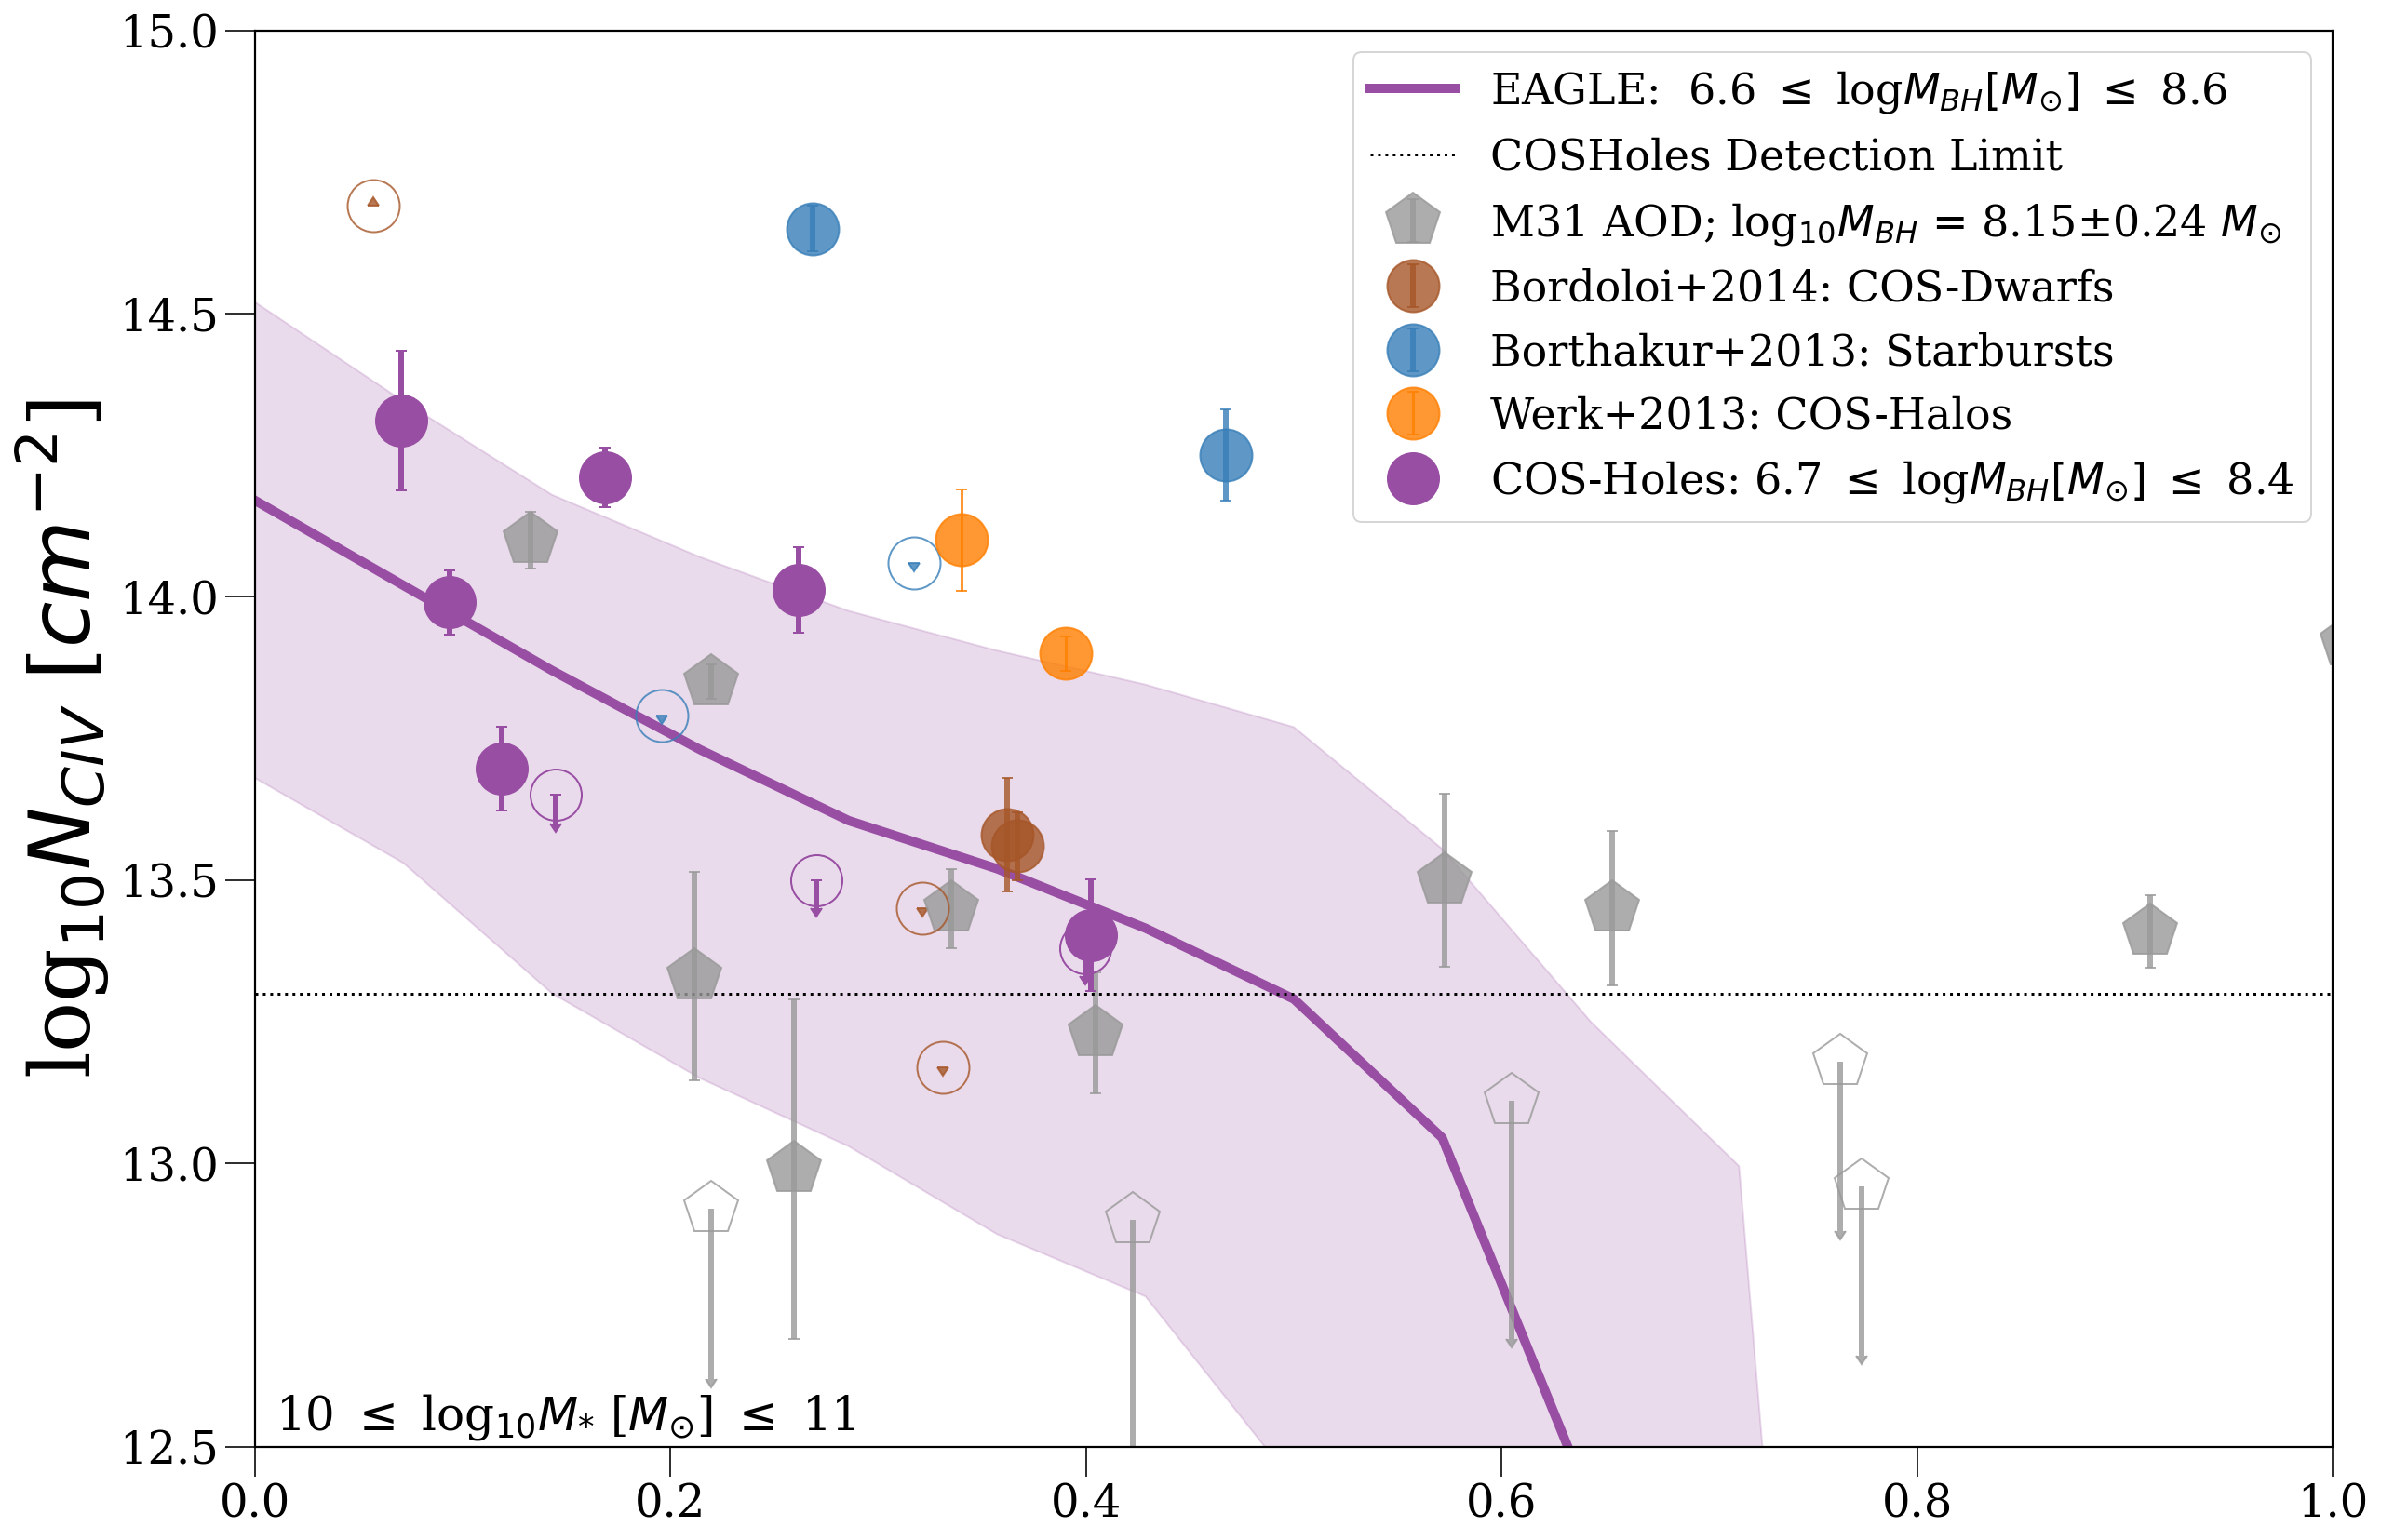

In [108]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#EAGLE

plt.fill_between((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, 
                 (df_rr_new_low['16percentile'] + df_rr_new_high['16percentile'])/2, 
                 (df_rr_new_low['84percentile'] + df_rr_new_high['84percentile'])/2, alpha = 0.2, color = CB_color_cycle[5])
plt.plot((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, (df_rr_new_low['median'] + df_rr_new_high['median'])/2, 
         color = CB_color_cycle[5], lw = 5, label = 'EAGLE:  6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha=0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

############### Stellar Mass (10-11) Literature Sample ##############

#Non-Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][:2], bordoloi_high['logNCIV'][:2], yerr = bordoloi_high['err'][:2], capsize=3,c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit

    #Borthakur 
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][:2], borthakur_high['logNCIV[i]'][:2], yerr = borthakur_high['err'][:2], capsize=3, 
                c = CB_color_cycle[0], alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit
#Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][2:4], bordoloi_high['logNCIV'][2:4], yerr = bordoloi_high['err'][2:4], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', label = 'Bordoloi+2014: COS-Dwarfs', elinewidth=3)
plt.errorbar(bordoloi_high['R/Rvir'][4:], bordoloi_high['logNCIV'][4:], yerr = bordoloi_high['err'][4:], capsize=3, c =CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', lolims=True, elinewidth=3) #lower limit 
    #Borthakur
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][2:], borthakur_high['logNCIV[i]'][2:], yerr = borthakur_high['err'][2:], capsize=3, 
                alpha=0.8, c = CB_color_cycle[0], marker = 'o', markersize = 28, ls='none', label = 'Borthakur+2013: Starbursts', elinewidth=3) 

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for colour, label in zip([CB_color_cycle[5]], [r"COS-Holes: 6.7 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.4"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"], sum_ch['N'],yerr=sum_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"], up_ch['N'], yerr=up_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

plt.annotate('10 $\leq$ log$_{10}M_{*}$ [$M_{\odot}$] $\leq$ 11', (0.01, 12.53), fontsize=25)
ax.legend(loc=1, fontsize=23)
#ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 1)
plt.show()

#### R25

In [35]:
#R25 Data (CHaNGA Models)

R25_HMbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/R25_highMbh_logN_CIV.txt', 
                           sep=" ", header=None, names =['R25_HMbh_civ'])
R25_LMbh_civ = pd.read_csv('/Users/samgarza/Documents//COS-Holes/R25/R25_lowMbh_logN_CIV.txt', 
                           sep=" ", header=None, names =['R25_LMbh_civ'])
R25_RpRv = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/R25_RoverRvir.txt', 
                       sep=" ", header=None, names =['R25_RpRv'])

R25_df_rr = pd.concat([R25_HMbh_civ, R25_LMbh_civ, R25_RpRv], axis=1, join='inner')
#R25_df_rr

<>:10: DeprecationWarning: invalid escape sequence \l
<>:19: DeprecationWarning: invalid escape sequence \p
<>:66: DeprecationWarning: invalid escape sequence \l
<>:10: DeprecationWarning: invalid escape sequence \l
<>:19: DeprecationWarning: invalid escape sequence \p
<>:66: DeprecationWarning: invalid escape sequence \l
<>:10: DeprecationWarning: invalid escape sequence \l
<>:19: DeprecationWarning: invalid escape sequence \p
<>:66: DeprecationWarning: invalid escape sequence \l
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/1883712342.py:10: DeprecationWarning: invalid escape sequence \l
  c = CB_color_cycle[5], linewidth = 5, ls = ':', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/1883712342.py:19: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)
/var/folders/cm/

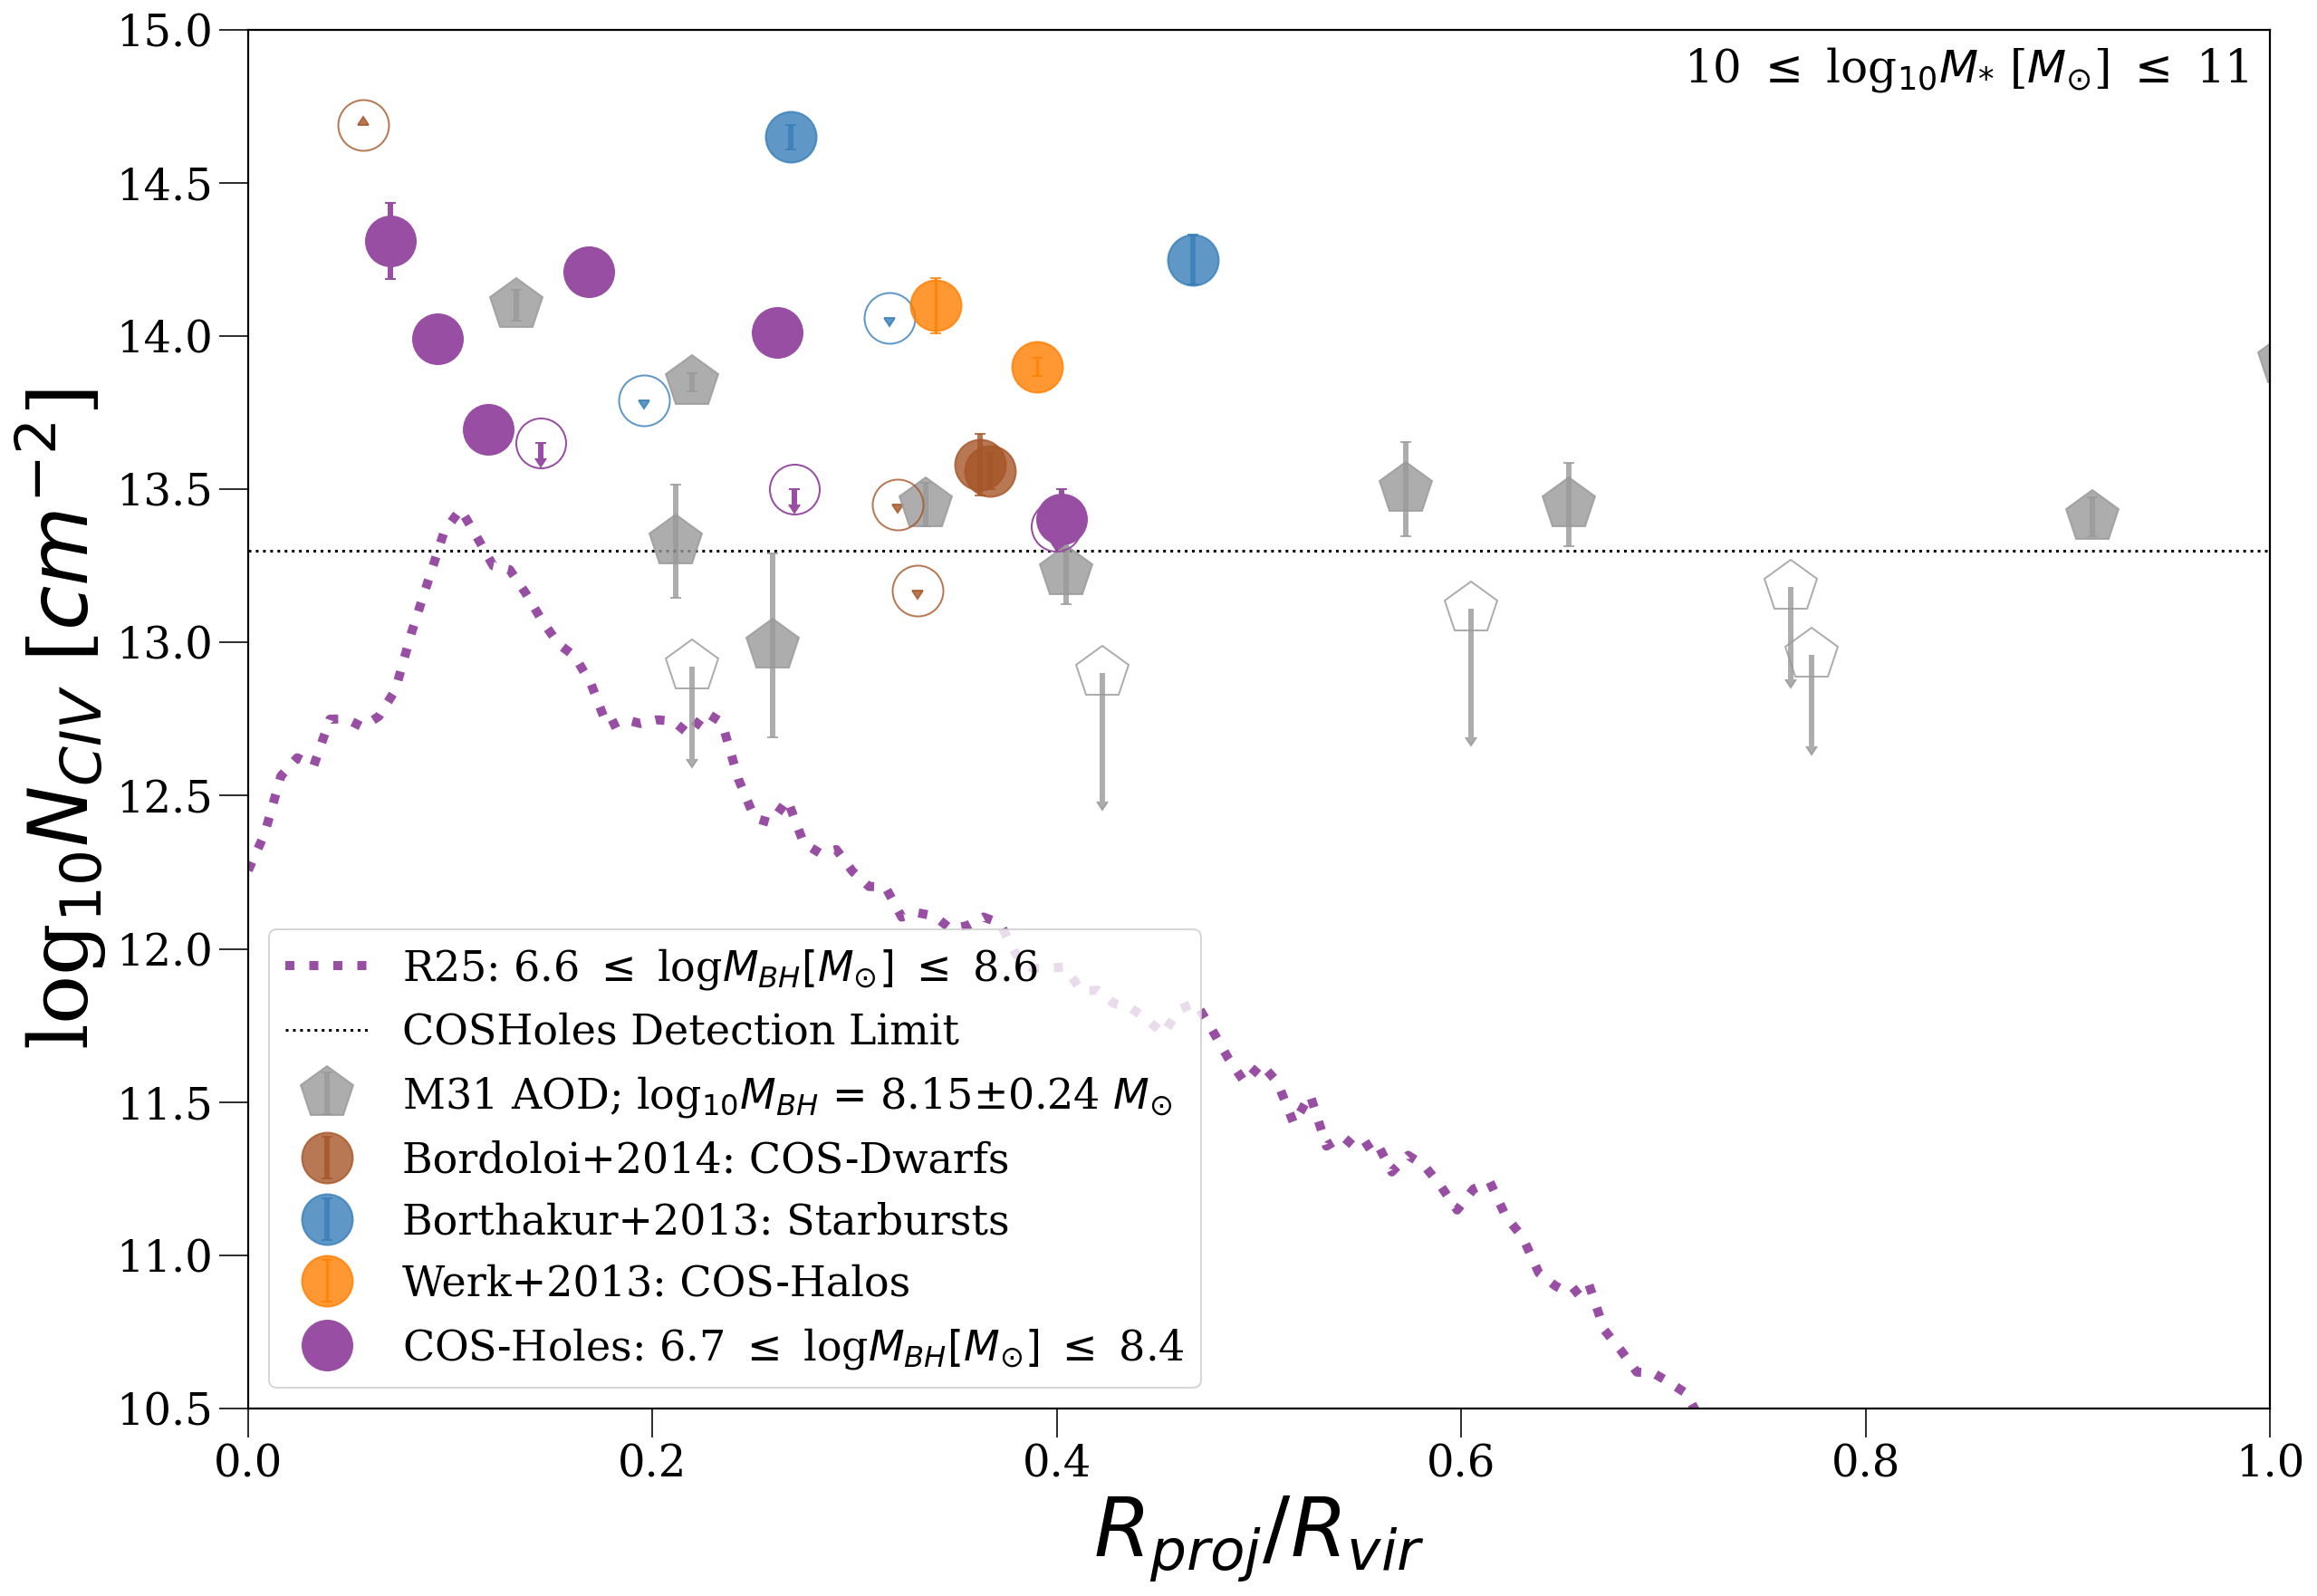

In [110]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#R25

plt.plot((R25_df_rr['R25_RpRv'] + R25_df_rr['R25_RpRv'])/2, (R25_df_rr['R25_LMbh_civ']+ R25_df_rr['R25_HMbh_civ'])/2, 
         c = CB_color_cycle[5], linewidth = 5, ls = ':', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

########## Literature Data ##########

############### Stellar Mass (10-11) Literature Sample ##############

#Non-Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][:2], bordoloi_high['logNCIV'][:2], yerr = bordoloi_high['err'][:2], capsize=3,c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit

    #Borthakur 
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][:2], borthakur_high['logNCIV[i]'][:2], yerr = borthakur_high['err'][:2], capsize=3, 
                c = CB_color_cycle[0], alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit
#Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][2:4], bordoloi_high['logNCIV'][2:4], yerr = bordoloi_high['err'][2:4], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', label = 'Bordoloi+2014: COS-Dwarfs', elinewidth=3)
plt.errorbar(bordoloi_high['R/Rvir'][4:], bordoloi_high['logNCIV'][4:], yerr = bordoloi_high['err'][4:], capsize=3, c =CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', lolims=True, elinewidth=3) #lower limit 
    #Borthakur
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][2:], borthakur_high['logNCIV[i]'][2:], yerr = borthakur_high['err'][2:], capsize=3, 
                alpha=0.8, c = CB_color_cycle[0], marker = 'o', markersize = 28, ls='none', label = 'Borthakur+2013: Starbursts', elinewidth=3) 

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for colour, label in zip([CB_color_cycle[5]], [r"COS-Holes: 6.7 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.4"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"], sum_ch['N'],yerr=sum_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"], up_ch['N'], yerr=up_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

plt.annotate('10 $\leq$ log$_{10}M_{*}$ [$M_{\odot}$] $\leq$ 11', (0.71, 14.83), fontsize=25)
ax.legend(loc=3, fontsize=23)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(10.5, 15)
ax.set_xlim(0, 1)
#plt.savefig('Figures/nciv_r25sum_vs_rr.png')
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \l
<>:18: DeprecationWarning: invalid escape sequence \l
<>:27: DeprecationWarning: invalid escape sequence \p
<>:74: DeprecationWarning: invalid escape sequence \l
<>:10: DeprecationWarning: invalid escape sequence \l
<>:18: DeprecationWarning: invalid escape sequence \l
<>:27: DeprecationWarning: invalid escape sequence \p
<>:74: DeprecationWarning: invalid escape sequence \l
<>:10: DeprecationWarning: invalid escape sequence \l
<>:18: DeprecationWarning: invalid escape sequence \l
<>:27: DeprecationWarning: invalid escape sequence \p
<>:74: DeprecationWarning: invalid escape sequence \l
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/359684294.py:10: DeprecationWarning: invalid escape sequence \l
  c = 'slateblue', linewidth = 5, ls = '--', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3783/359684294.py:18: DeprecationWarning: invalid escape s

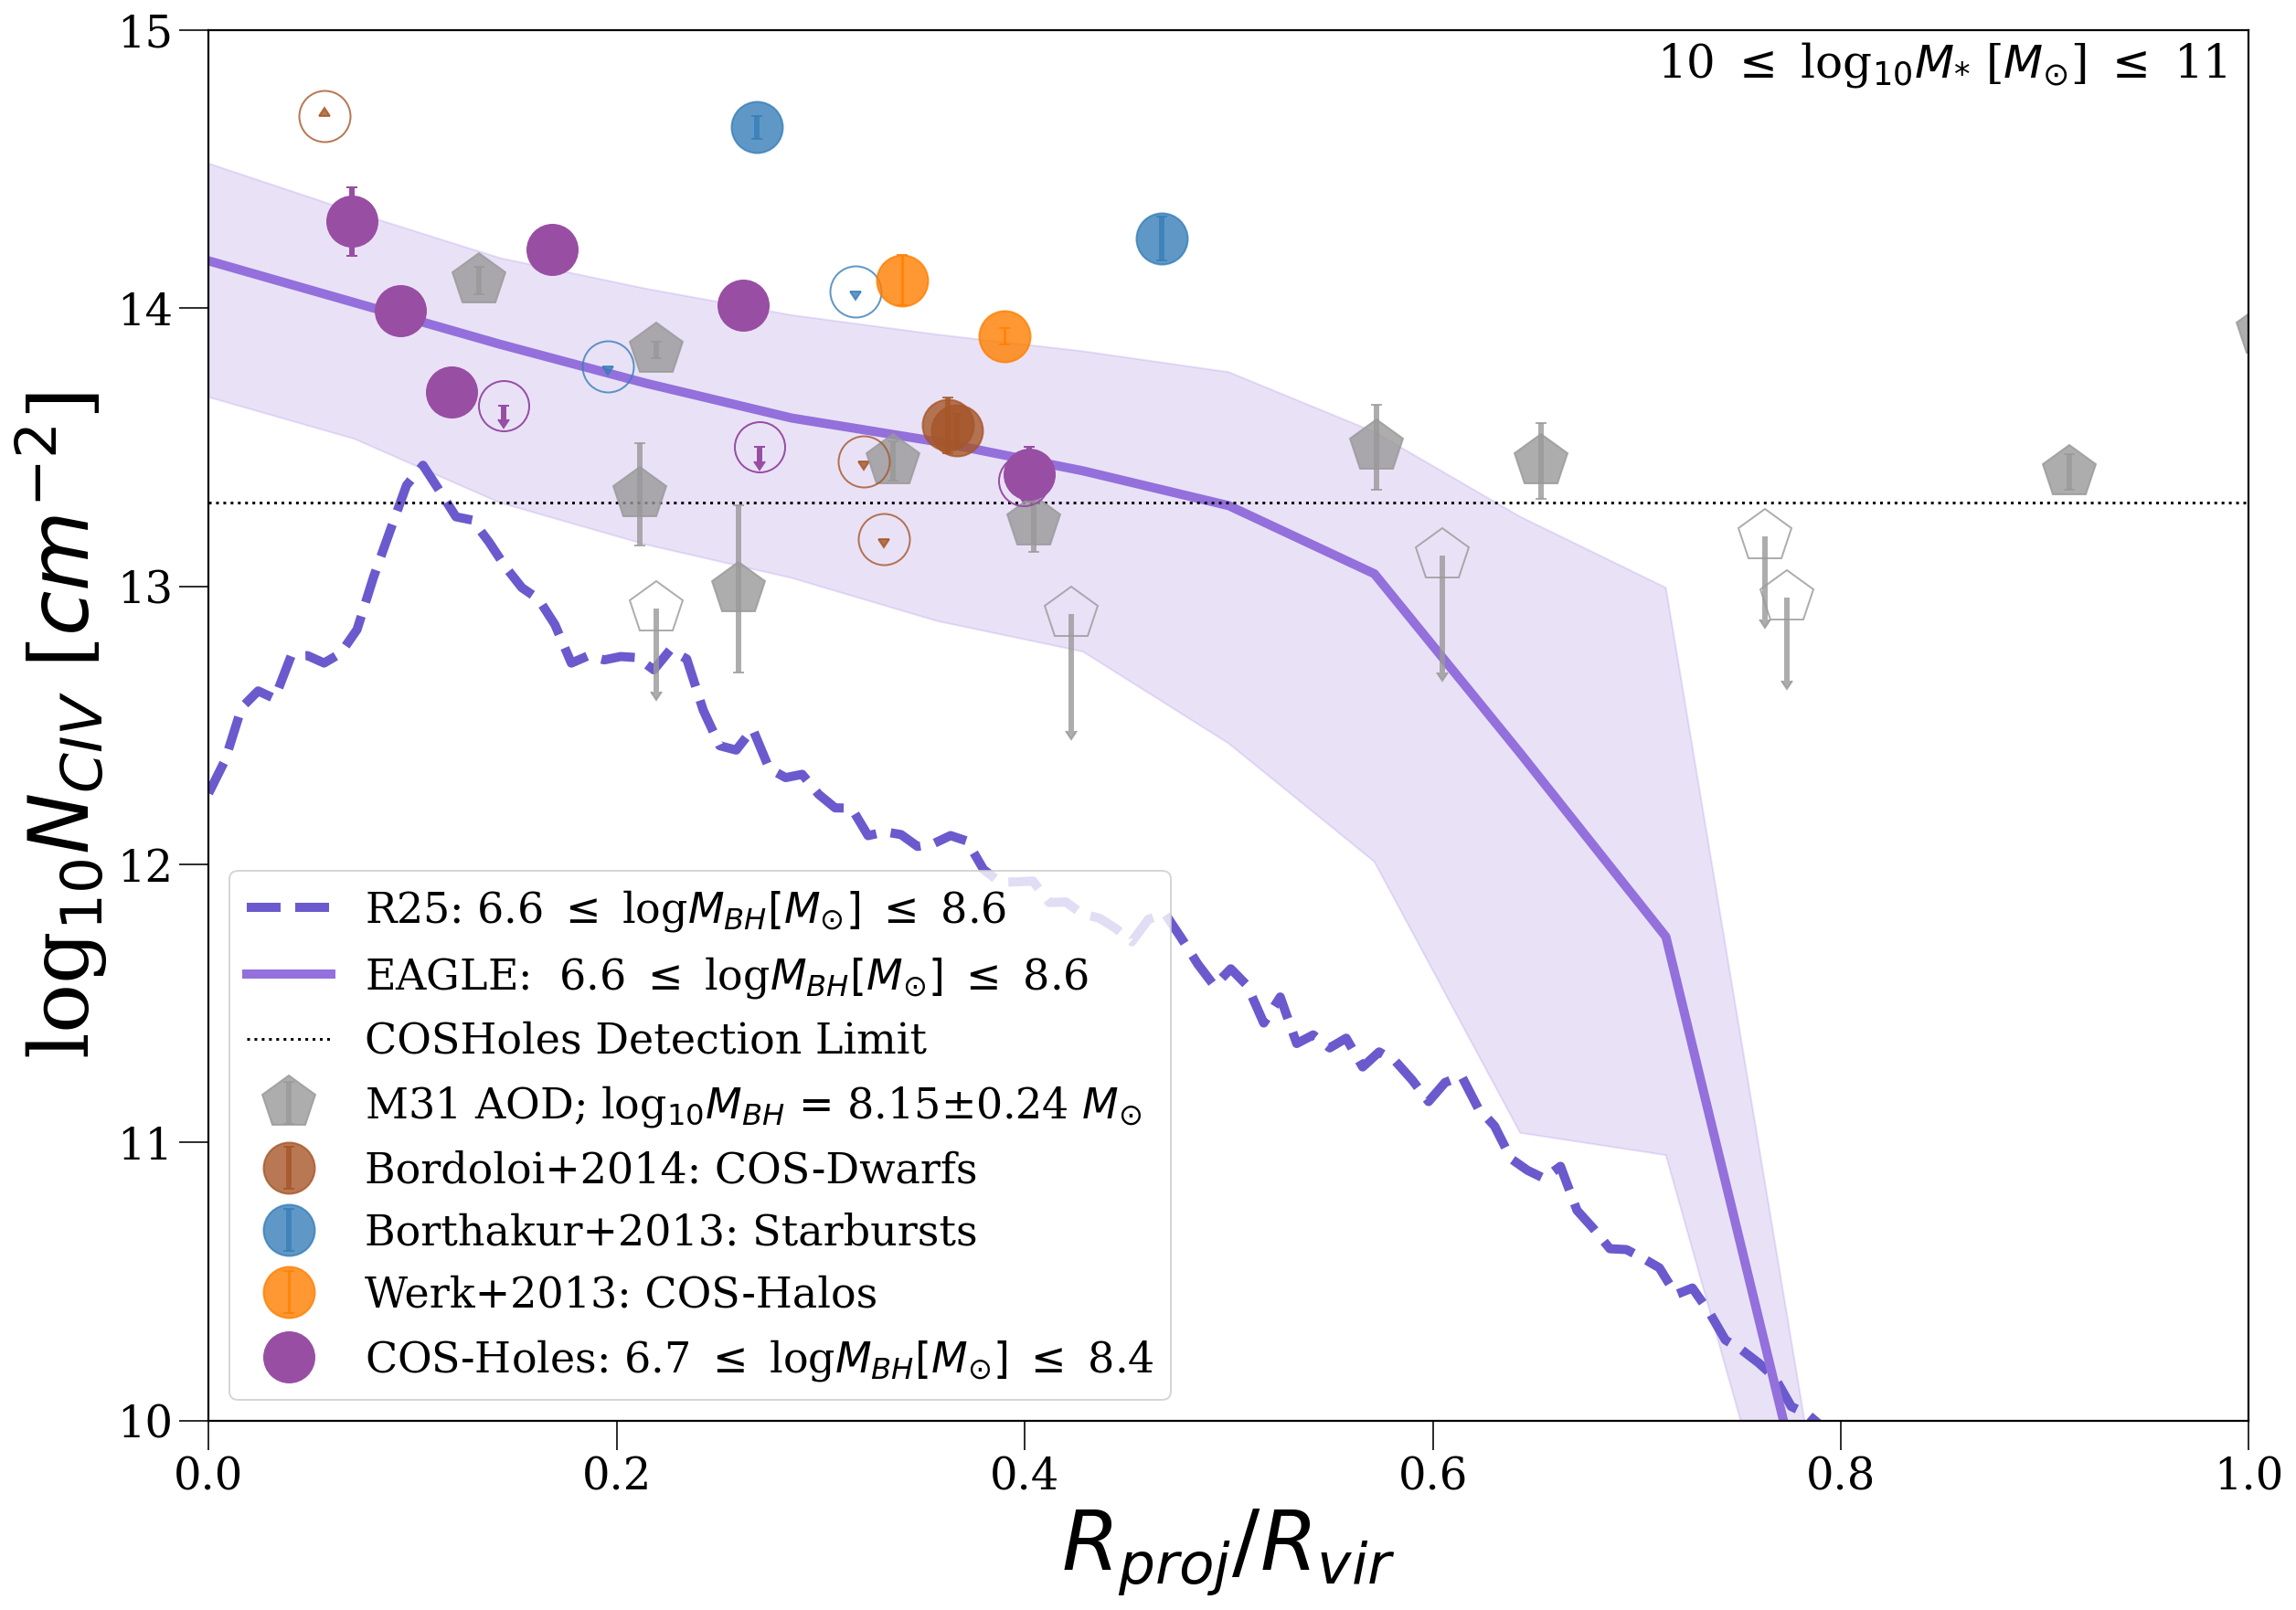

In [123]:
#Plotting NCIV vs Rproj/Rvir Just One large sample instead of high and low with both simulations on there 

fig, ax = plt.subplots()

########################################################

#R25

plt.plot((R25_df_rr['R25_RpRv'] + R25_df_rr['R25_RpRv'])/2, (R25_df_rr['R25_LMbh_civ']+ R25_df_rr['R25_HMbh_civ'])/2, 
         c = 'slateblue', linewidth = 5, ls = '--', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

#EAGLE

plt.fill_between((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, 
                 (df_rr_new_low['16percentile'] + df_rr_new_high['16percentile'])/2, 
                 (df_rr_new_low['84percentile'] + df_rr_new_high['84percentile'])/2, alpha = 0.2, color = 'mediumpurple')
plt.plot((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, (df_rr_new_low['median'] + df_rr_new_high['median'])/2, 
         color = 'mediumpurple', lw = 5, label = 'EAGLE:  6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

########## Literature Data ##########

############### Stellar Mass (10-11) Literature Sample ##############

#Non-Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][:2], bordoloi_high['logNCIV'][:2], yerr = bordoloi_high['err'][:2], capsize=3,c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit

    #Borthakur 
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][:2], borthakur_high['logNCIV[i]'][:2], yerr = borthakur_high['err'][:2], capsize=3, 
                c = CB_color_cycle[0], alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit
#Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][2:4], bordoloi_high['logNCIV'][2:4], yerr = bordoloi_high['err'][2:4], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', label = 'Bordoloi+2014: COS-Dwarfs', elinewidth=3)
plt.errorbar(bordoloi_high['R/Rvir'][4:], bordoloi_high['logNCIV'][4:], yerr = bordoloi_high['err'][4:], capsize=3, c =CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', lolims=True, elinewidth=3) #lower limit 
    #Borthakur
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][2:], borthakur_high['logNCIV[i]'][2:], yerr = borthakur_high['err'][2:], capsize=3, 
                alpha=0.8, c = CB_color_cycle[0], marker = 'o', markersize = 28, ls='none', label = 'Borthakur+2013: Starbursts', elinewidth=3) 

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for colour, label in zip([CB_color_cycle[5]], [r"COS-Holes: 6.7 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.4"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"], sum_ch['N'],yerr=sum_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"], up_ch['N'], yerr=up_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

plt.annotate('10 $\leq$ log$_{10}M_{*}$ [$M_{\odot}$] $\leq$ 11', (0.71, 14.83), fontsize=25)
ax.legend(loc=3, fontsize=23)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(10, 15)
ax.set_xlim(0, 1)
#plt.savefig('Figures/nciv_r25sum_vs_rr.png')
plt.show()